# Example of ARMA forecasting
- Goal: predicting bandwidth usage for a large data center in the next 2 hours. 
    - Bandwidth is defined as the maximum rate of data that can be transferred. Its base unit is bits per second (bps).
    - Forecasting bandwidth usage allows data centers to better manage their computing resources.
- Dataset: there are 10,000 data points representing the hourly bandwidth usage starting in January 1, 2019. (measured in megabits per second (Mbps), which is equivalent to 106 bps)

In [30]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from itertools import product
from tqdm import tqdm
from typing import Union
import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/bandwidth.csv")

In [3]:
fig = px.line(df['hourly_bandwidth'])
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = np.arange(0, 10000, 730),
        ticktext = ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb']
    ),
    yaxis_title='Hourly bandwith usage (MBps)',
    xaxis_title='Time',
    title='Hourly bandwidth usage in a data center since January 1, 2019. '
)  

- From the plot, there is long-term trends over time, meaning that this series is likely not stationary, so we need to apply a transformation. 
- Also, there seems to be no cyclical behavior, so we can rule out the presence of seasonality in our series.
- In order to forecast bandwidth usage, we need to identify the underlying process in our series.

## EDA 

### Stationarity

In [4]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [5]:
check_stationarity(df["hourly_bandwidth"])

ADF Statistic : -0.87147, p-value: 0.79722
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Statistic: 9.52772, p-value: 0.01000
Non-stationary


In [6]:
# The time series is not stationary.
# Apply a transformation to our data in order to make it stationary. Let’s apply a first-order differencing using numpy.
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)
check_stationarity(bandwidth_diff)

ADF Statistic : -20.69485, p-value: 0.00000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.32719, p-value: 0.10000
Stationary


### Auto-correlation

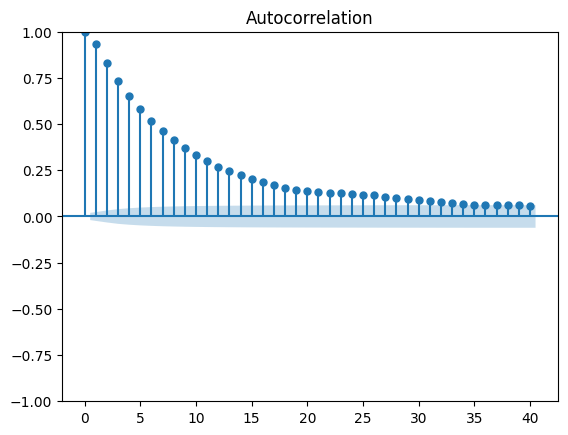

In [8]:
plot_acf(bandwidth_diff);

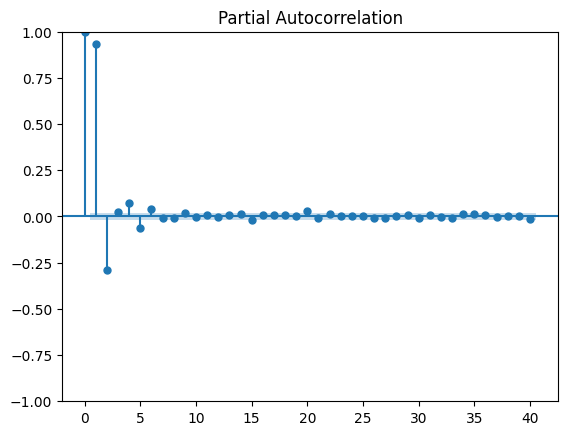

In [9]:
plot_pacf(bandwidth_diff);

- Since it is difficult to conclude from the ACF if the (differenced) stationary series is MA(q) process or from the PACF if the (differenced) stationary series is AR(p) process. 
- Hence, this could be ARMA(p, q) process, so we will proceed with the **general modeling procedure** to determine the order of p and q.

## Applying the general modeling procedure

In [10]:
# train-test split
# keep the last 7 days of data for the test set, so totals 168 hours.
# since our forecasts are for the next 2 hours, the test set thus contains 84 periods of 2 hours on which to evaluate our models’ performance.
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
train = df_diff[:-168]
test = df_diff[-168:]
print(len(train))
print(len(test))

9831
168


- With our train set ready, we can now fit different $ARMA(p,q)$ models using the `optimize_ARMA` function.
- The `optimize_ARMA` function takes the training data and the list of unique (p,q) combinations as input, and then we iterate over each (p,q) combination and fit an ARMA(p,q) model on our data. We compute the AIC, store the result, and sort by AIC value in ascending order as the lower the AIC, the better the model. 

In [13]:
# fit all unique 16 ARMA(p,q) models to the data
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            p, q = order
            model = SARIMAX(endog, 
                            order=(p, 0, q), 
                            simple_differencing=False # prevent differencing.
                            ).fit(disp=False) # avoid printing convergence messages to the console.
        except:
            continue
        # calculate the model’s AIC. 
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# define a list of (p, q)
ps = range(0, 4, 1)    # The order p can have the values {0,1,2,3}               
qs = range(0, 4, 1)    # The order q can have the values {0,1,2,3}             
 
order_list = list(product(ps, qs)) 

In [14]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df.head()

100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550


- The first three models all have an AIC of 27,991, with only slight differences.
- In this case, ARMA(2,2) model is selected as its AIC value is very close to the ARMA(3,2) and ARMA(2,3) models, while being less complex

### Analysis of the Model’s Residuals
- To perform the residual analysis, we’ll fit the ARMA(2,2) model on our training set. 
- Use the `plot_diagnostics` method to study the Q-Q plot

In [15]:
model = SARIMAX(train['bandwidth_diff'],
                order=(2,0,2),
                simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Mon, 20 May 2024   AIC                          27991.604
Time:                        11:35:28   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

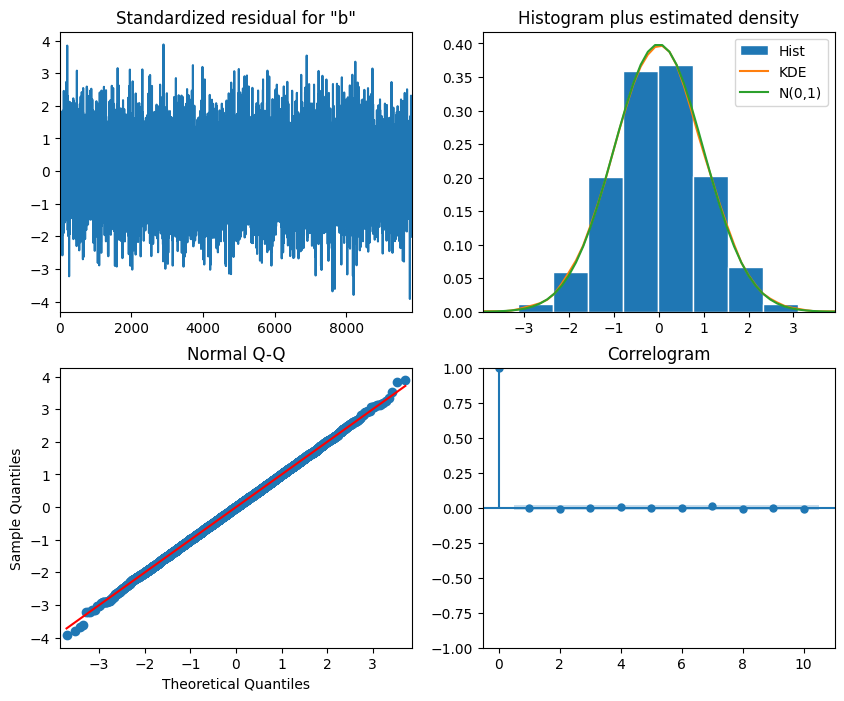

In [16]:
model_fit.plot_diagnostics(figsize=(10, 8));
#plt.savefig('figures/CH06_F19_peixeiro.png', dpi=300)

- The top-left plot shows no trend, and the mean seems constant over time, meaning that our residuals are likely **stationary**. 
- The top right displays a density plot with a shape similar to that of a **normal distribution**. 
- The Q-Q plot at the bottom left shows a thick straight line that is very close to y = x. 
- The ACF plot at the bottom right shows no autocorrelation after lag 0. 
- Summary: the above figures indicates that our residuals clearly resemble **white noise**, since they are *normally* distributed and *uncorrelated*.

- Last step: the Ljung-Box test on the residuals for the first 10 lags.
    - If the returned p-values exceed 0.05, we cannot reject the null hypothesis, which means that our residuals are uncorrelated and independently distributed, just like white noise.

In [23]:
residuals = model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

True

- The returned p-values all exceed 0.05.
- Therefore, we can conclude that our residuals are indeed uncorrelated. Our ARMA(2,2) model has passed all the checks on the residual analysis, and we are ready to use this model to forecast bandwidth usage.

## Forecasting bandwidth usage
- Use `rolling_forecast` function to evaluate the performance of the different forecasting methods.
-  We will predict two steps at a time

In [24]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [25]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2 # 2 steps at the time for the prediction

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_diff[-200:].index, y=df_diff[-200:]['bandwidth_diff'], name='actual', line = dict(color='royalblue')))

for pred_type in ["pred_mean", "pred_last_value","pred_ARMA"]: 
    fig.add_trace(go.Scatter(x=test.index, y=test[pred_type], name=pred_type, line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [9802, 9850, 9898, 9946, 9994],
        ticktext = ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']
    ),
    yaxis_title='Hourly bandwidth - Diff (MBps)',
    xaxis_title='Time',
    title='Forecasts of the <b>differenced</b> hourly BW'
)  
fig.show()

- The forecasts using the mean, shown as a dotted line, are completely flat over the testing period.
    - This is expected as the differenced series is stationary.

In [31]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462114206054


-  The ARMA(2,2) model (MSE=1.769) outperforms the benchmarks: mean method (MSE=6.3) and last known value (MSE=2.2)

- The final step is to reverse the transformation of our forecast in order to bring it to the same scale as our original data

In [32]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9831] + test['pred_ARMA'].cumsum()

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-200:].index, y=df[-200:]["hourly_bandwidth"], name='actual', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df[-200:].index, y=df[-200:]["pred_bandwidth"], name='ARMA(2,2) pred', line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [9802, 9850, 9898, 9946, 9994],
        ticktext = ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21']
    ),
    yaxis_title='Hourly bandwidth (MBps)',
    xaxis_title='Time',
    title='Forecasts of the hourly BW'
)  
fig.show()

In [36]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

8.412254082453925


- On average, our forecasts are 8.4 Mbps above or below the actual bandwidth usage